To validate battery base model for LG M50, Use revised OKane2022 parameters with parameters used in Paper 1,2  
1. To validate BoL voltage and thermal response

In [1]:
import pybamm
import matplotlib.pyplot as plt
import numpy as np
def Overwrite_Initial_L_SEI_0_Neg_Porosity(Para_0,cap_loss):
    """
    This is to overwrite the initial negative electrode porosity
    and initial SEI thickness (inner, outer) to be consistent
    with the initial capacity loss
    """
    delta_Q_SEI = cap_loss * 3600
    V_SEI = Para_0["Negative outer SEI partial molar volume [m3.mol-1]"]
    # do this when finish updating
    F = 96485.3
    A = Para_0["Electrode width [m]"] * Para_0["Electrode height [m]"]
    z_SEI = Para_0["Negative ratio of lithium moles to SEI moles"]
    L_neg = Para_0["Negative electrode thickness [m]"]
    eps_act_neg = Para_0["Negative electrode active material volume fraction"]
    R_neg =   Para_0["Negative particle radius [m]"]
    l_cr_init = Para_0["Negative electrode initial crack length [m]"]
    w_cr = Para_0["Negative electrode initial crack width [m]"]
    rho_cr = Para_0["Negative electrode number of cracks per unit area [m-2]"]
    a_neg = (3 * eps_act_neg / R_neg)
    roughness = 1 + 2 * l_cr_init * w_cr * rho_cr
    L_SEI_init = delta_Q_SEI  * V_SEI / (
        z_SEI * F * A * L_neg * a_neg * roughness)
 
    delta_epi = (L_SEI_init ) * roughness * a_neg
    L_inner_init = L_SEI_init / 2
    epi = 0.25 - delta_epi
    # print(L_inner_init,epi)
    # important: update here!
    Para_0["Negative electrode porosity"] = epi
    Para_0["Negative initial outer SEI thickness [m]"] = L_inner_init + 2.5e-9
    Para_0["Negative initial inner SEI thickness [m]"] = L_inner_init + 2.5e-9
    ## add Xinlei
    Para_0["Initial inner SEI thickness [m]"] = L_inner_init + 2.5e-9
    Para_0["Initial outer SEI thickness [m]"] = L_inner_init + 2.5e-9
    print(f"Has Overwritten Initial outer SEI thickness [m] to be {(L_inner_init+2.5e-9):.2e} and Negative electrode porosity to be {epi:.3f} to account for initial capacity loss of {cap_loss:.3f} Ah")
    print(f"Has Overwritten Initial outer SEI thickness [m] to be {(L_inner_init+2.5e-9):.2e} and Negative electrode porosity to be {epi:.3f} to account for initial capacity loss of {cap_loss:.3f} Ah")
 
    return Para_0

param = pybamm.ParameterValues("OKane2023_Xinlei")

Overwrite_Initial_L_SEI_0_Neg_Porosity(param,0.15)

Has Overwritten Initial outer SEI thickness [m] to be 1.62e-08 and Negative electrode porosity to be 0.219 to account for initial capacity loss of 0.150 Ah
Has Overwritten Initial outer SEI thickness [m] to be 1.62e-08 and Negative electrode porosity to be 0.219 to account for initial capacity loss of 0.150 Ah


{'Ambient temperature [K]': 298.15,
 'Boltzmann constant [J.K-1]': 1.380649e-23,
 'Bulk solvent concentration [mol.m-3]': 2636.0,
 'Cation transference number': <function electrolyte_transference_number_EC_EMC_3_7_Landesfeind2019_Constant at 0x7f8a1b4c41f0>,
 'Cell cooling surface area [m2]': 0.00531,
 'Cell thermal expansion coefficient [m.K-1]': 1.1e-06,
 'Cell volume [m3]': 2.42e-05,
 'Contact resistance [Ohm]': 0.013,
 'Current function [A]': 5.0,
 'Dead lithium decay constant [s-1]': 1e-06,
 'Dead lithium decay rate [s-1]': <function SEI_limited_dead_lithium_OKane2022 at 0x7f8a1b4dc4c0>,
 'EC diffusivity [m2.s-1]': 2e-18,
 'EC initial concentration in electrolyte [mol.m-3]': 4541.0,
 'EC partial molar volume [m3.mol-1]': 6.667e-05,
 'Electrode height [m]': 0.065,
 'Electrode width [m]': 1.58,
 'Electrolyte conductivity [S.m-1]': <function electrolyte_conductivity_EC_EMC_3_7_Landesfeind2019_Constant at 0x7f8a1b4c43a0>,
 'Electrolyte diffusivity [m2.s-1]': <function electrolyte_diff

In [8]:

import pybamm
import matplotlib.pyplot as plt
import numpy as np


model = pybamm.lithium_ion.DFN(
    {
        #"particle phases": ("2", "1"),
        #"open-circuit potential": (("single", "current sigmoid"), "single"),
        "open-circuit potential": "current sigmoid",
        "SEI": "solvent-diffusion limited",
        #"SEI": "interstitial-diffusion limited",
        "SEI porosity change": "true",
        "lithium plating": "partially reversible",
        "lithium plating porosity change": "true",  # alias for "SEI porosity change"
        "particle mechanics": ("swelling and cracking", "swelling only"),
        "SEI on cracks": "true",
        "loss of active material": "stress-driven",
        "calculate discharge energy": "true",  # for compatibility with older PyBaMM versions

        "thermal": "lumped", 
    }
)

#param = pybamm.ParameterValues("OKane2023_Xinlei")

var_pts = {
    "x_n": 10,  # negative electrode
    "x_s": 10,  # separator
    "x_p": 10,  # positive electrode
    "r_n": 30,  # negative particle
    "r_p": 30,  # positive particle
}

cycle_number = 1
exp = pybamm.Experiment(
    # [
    #     "Hold at 4.2 V until C/100 (5 minute period)",
    #     "Rest for 4 hours (5 minute period)",
    #     "Discharge at 0.1C until 2.5 V (5 minute period)",  # initial capacity check
    #     "Charge at 1C until 4.2 V (5 minute period)",
    #     "Hold at 4.2 V until C/100 (5 minute period)",
    # ]
    # + 
    [
        (
            "Charge at 0.3C until 4.2 V",
            "Hold at 4.2 V until C/20",
            "Discharge at 1C until 2.5 V",  # ageing cycles
            #"Discharge at 1C until 2.5 V"

        )
    ]
    * cycle_number
    #+ ["Discharge at 0.1C until 2.5 V (5 minute period)"],  # final capacity check
)

# exp = pybamm.Experiment(
#     [
#         "Hold at 4.2 V until C/100 (5 minute period)",
#         "Discharge at 0.1C until 2.5 V (5 minute period)",  # initial capacity check
#         "Charge at 0.1C until 4.2 V (5 minute period)",
#         "Hold at 4.2 V until C/100 (5 minute period)",
#     ]
# )


sim = pybamm.Simulation(model, parameter_values=param, experiment=exp, var_pts=var_pts )
#sim_thermal = pybamm.Simulation(model_thermal, parameter_values=param, experiment=exp, var_pts=var_pts)
sol = sim.solve(initial_soc=0)
#sol = sim.solve()


KeyboardInterrupt: 

In [2]:

model_nodeg = pybamm.lithium_ion.DFN(
    {
        #"particle phases": ("2", "1"),
        #"open-circuit potential": (("single", "current sigmoid"), "single"),
        "open-circuit potential": "current sigmoid",
        # "SEI": "solvent-diffusion limited",
        # "SEI porosity change": "true",
        # "lithium plating": "partially reversible",
        # "lithium plating porosity change": "true",  # alias for "SEI porosity change"
        # "particle mechanics": ("swelling and cracking", "swelling only"),
        # "SEI on cracks": "true",
        # "loss of active material": "stress-driven",
        # "calculate discharge energy": "true",  # for compatibility with older PyBaMM versions

        "thermal": "lumped", 
    }
)

#param = pybamm.ParameterValues("OKane2023_Xinlei")
var_pts = {
    "x_n": 10,  # negative electrode
    "x_s": 10,  # separator
    "x_p": 10,  # positive electrode
    "r_n": 30,  # negative particle
    "r_p": 30,  # positive particle
}

cycle_number = 1
exp = pybamm.Experiment(
    # [
    #     "Hold at 4.2 V until C/100 (5 minute period)",
    #     "Rest for 4 hours (5 minute period)",
    #     "Discharge at 0.1C until 2.5 V (5 minute period)",  # initial capacity check
    #     "Charge at 1C until 4.2 V (5 minute period)",
    #     "Hold at 4.2 V until C/100 (5 minute period)",
    # ]
    # + 
    [
        (
            "Charge at 0.3C until 4.2 V",
            "Hold at 4.2 V until C/20",
            "Discharge at 1C until 2.5 V",  # ageing cycles
            #"Discharge at 1C until 2.5 V"

        )
    ]
    * cycle_number
    #+ ["Discharge at 0.1C until 2.5 V (5 minute period)"],  # final capacity check
)

# exp = pybamm.Experiment(
#     [
#         "Hold at 4.2 V until C/100 (5 minute period)",
#         "Discharge at 0.1C until 2.5 V (5 minute period)",  # initial capacity check
#         "Charge at 0.1C until 4.2 V (5 minute period)",
#         "Hold at 4.2 V until C/100 (5 minute period)",
#     ]
# )


sim_nodeg = pybamm.Simulation(model_nodeg, parameter_values=param, experiment=exp, var_pts=var_pts )
#sim_thermal = pybamm.Simulation(model_thermal, parameter_values=param, experiment=exp, var_pts=var_pts)
sol_nodeg = sim_nodeg.solve(initial_soc=0)
#sol = sim.solve()

At t = 492.1 and h = 3.26075e-15, the corrector convergence failed repeatedly or with |h| = hmin.


In [4]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
cwd = os.getcwd()


# 读取 pickle 文件
#pickle_file_path = cwd + '/docs/source/examples/notebooks/models/exp_LG/processed_data.pkl'
pickle_file_path = cwd + '/exp_LG/processed_data.pkl'
cycles_df = pd.read_pickle(pickle_file_path)
print("DataFrame loaded from pickle file")
print(cycles_df.head())

DataFrame loaded from pickle file
            Mode  RelativeTime   Voltage          I  Q_dis     Q_cha  \
Cycle Step                                                             
1     1      1.0        0.0000  2.680430  1407.8055    0.0  0.000078   
      2      1.0        0.0084  2.690530  1574.4427    0.0  0.003691   
      3      1.0        0.0294  2.700598  1640.2499    0.0  0.013108   
      4      1.0        0.0634  2.710643  1664.4644    0.0  0.028749   
      5      1.0        0.1074  2.720645  1668.5892    0.0  0.049123   

                 Cap         R    Pressure  Temperature  
Cycle Step                                               
1     1     0.000078  1.903978  159.026607      25.3794  
      2     0.003691  1.708878  158.944819      25.3885  
      3     0.013108  1.646455  158.998347      25.4014  
      4     0.028749  1.628537  159.049016      25.4088  
      5     0.049123  1.630506  158.990980      25.4014  


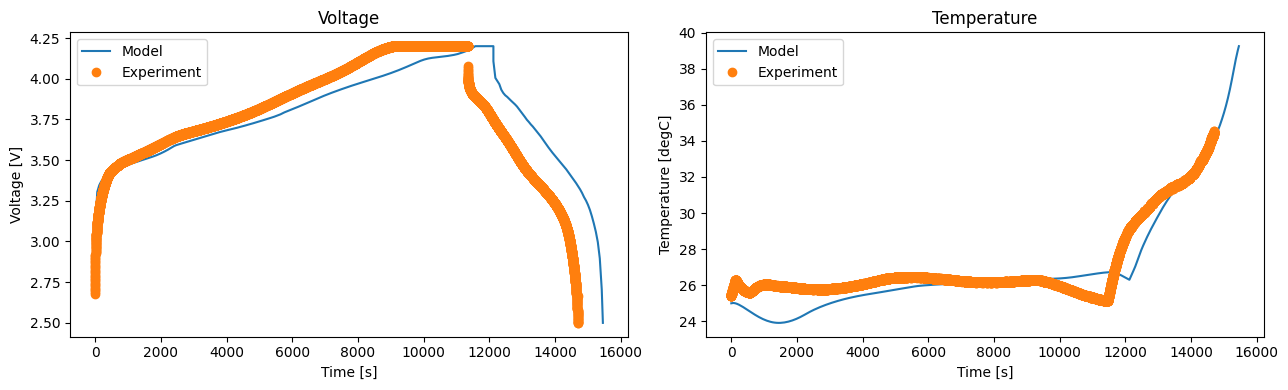

In [ ]:
# Compare model data to experiment including degradation

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(13, 4))

# plot the 1C results
t_sol = sol["Time [s]"].entries


ax1.plot(t_sol, sol["Voltage [V]"](t_sol))
ax1.plot(cycles_df.loc[1]["RelativeTime"],cycles_df.loc[1]["Voltage"], "o")
ax1.set_xlabel("Time [s]")
ax1.set_ylabel("Voltage [V]")
ax1.set_title("Voltage")
ax1.legend(["Model", "Experiment"], loc="best")


ax2.plot(t_sol, sol["X-averaged cell temperature [C]"](t_sol))
ax2.plot(cycles_df.loc[1]["RelativeTime"],cycles_df.loc[1]["Temperature"], "o")
ax2.set_xlabel("Time [s]")
ax2.set_ylabel("Temperature [degC]")
ax2.set_title("Temperature")
ax2.legend(["Model", "Experiment"], loc="best")

plt.tight_layout()
plt.show()

In [5]:
sol_nodeg["Discharge capacity [A.h]"].entries

array([ 0.        , -0.025     , -0.05      , -0.075     , -0.1       ,
       -0.125     , -0.15      , -0.175     , -0.2       , -0.225     ,
       -0.25      , -0.275     , -0.3       , -0.325     , -0.35      ,
       -0.375     , -0.4       , -0.425     , -0.45      , -0.475     ,
       -0.5       , -0.525     , -0.55      , -0.575     , -0.6       ,
       -0.625     , -0.65      , -0.675     , -0.7       , -0.725     ,
       -0.75      , -0.775     , -0.8       , -0.825     , -0.85      ,
       -0.875     , -0.9       , -0.925     , -0.95      , -0.975     ,
       -1.        , -1.025     , -1.05      , -1.075     , -1.1       ,
       -1.125     , -1.15      , -1.175     , -1.2       , -1.225     ,
       -1.25      , -1.275     , -1.3       , -1.325     , -1.35      ,
       -1.375     , -1.4       , -1.425     , -1.45      , -1.475     ,
       -1.5       , -1.525     , -1.55      , -1.575     , -1.6       ,
       -1.625     , -1.65      , -1.675     , -1.7       , -1.72

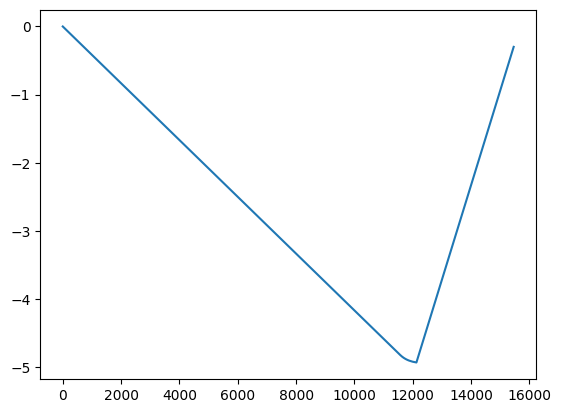

In [ ]:
plt.plot(sol["Time [s]"].entries,sol["Discharge capacity [A.h]"].entries )

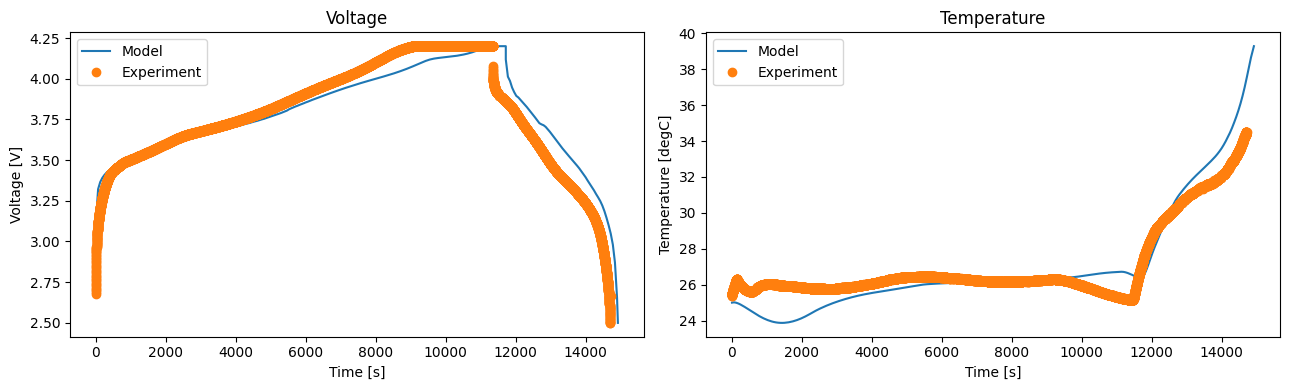

In [5]:
# Compare model data to experiment without degradation

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(13, 4))

# plot the 1C results
t_sol_nodeg = sol_nodeg["Time [s]"].entries


ax1.plot(t_sol_nodeg, sol_nodeg["Voltage [V]"](t_sol_nodeg))
ax1.plot(cycles_df.loc[1]["RelativeTime"],cycles_df.loc[1]["Voltage"], "o")
ax1.set_xlabel("Time [s]")
ax1.set_ylabel("Voltage [V]")
ax1.set_title("Voltage")
ax1.legend(["Model", "Experiment"], loc="best")


ax2.plot(t_sol_nodeg, sol_nodeg["X-averaged cell temperature [C]"](t_sol_nodeg))
ax2.plot(cycles_df.loc[1]["RelativeTime"],cycles_df.loc[1]["Temperature"], "o")
ax2.set_xlabel("Time [s]")
ax2.set_ylabel("Temperature [degC]")
ax2.set_title("Temperature")
ax2.legend(["Model", "Experiment"], loc="best")

plt.tight_layout()
plt.show()

In [ ]:
model.variables

{'Time [s]': Time(-0x2eb8ad56c5b4416a, time, children=[], domains={}),
 'Time [min]': Multiplication(-0xcfc348f95d23752, *, children=['0.016666666666666666', 'time'], domains={}),
 'Time [h]': Multiplication(-0x25ff2f3f620b87fe, *, children=['0.0002777777777777778', 'time'], domains={}),
 'x [m]': SpatialVariable(-0xf75d305b78b47c, x, children=[], domains={'primary': ['negative electrode', 'separator', 'positive electrode'], 'secondary': ['current collector']}),
 'x_n [m]': SpatialVariable(-0x3606ea53f70cef81, x_n, children=[], domains={'primary': ['negative electrode'], 'secondary': ['current collector']}),
 'x_s [m]': SpatialVariable(-0x173bfd721fb459ed, x_s, children=[], domains={'primary': ['separator'], 'secondary': ['current collector']}),
 'x_p [m]': SpatialVariable(-0x645f37c31ee6460, x_p, children=[], domains={'primary': ['positive electrode'], 'secondary': ['current collector']}),
 'r_n [m]': SpatialVariable(-0x1afa016ffc50f425, r_n, children=[], domains={'primary': ['negativ

In [ ]:
cycles_df

Mode  RelativeTime   Voltage          I        Q_dis     Q_cha  \
Cycle Step                                                                    
1     1       1.0  0.000000e+00  2.680430  1407.8055     0.000000  0.000078   
      2       1.0  8.400000e-03  2.690530  1574.4427     0.000000  0.003691   
      3       1.0  2.940000e-02  2.700598  1640.2499     0.000000  0.013108   
      4       1.0  6.340000e-02  2.710643  1664.4644     0.000000  0.028749   
      5       1.0  1.074000e-01  2.720645  1668.5892     0.000000  0.049123   
...           ...           ...       ...        ...          ...       ...   
105   14017   1.0  1.510170e+06  2.517027 -4997.5547  4461.105642  0.000000   
      14018   1.0  1.510171e+06  2.510488 -4997.8223  4462.493874  0.000000   
      14019   1.0  1.510172e+06  2.503801 -4997.8223  4463.882105  0.000000   
      14020   1.0  1.510173e+06  2.499954 -4997.1729  4464.662006  0.000000   
      14021   1.0  1.510173e+06  2.499981 -4997.4785  4464.662284  0.000000   

                     Cap         R    Pressure  Temperature  
Cycle Step                                                   
1     1         0.000078  1.903978  159.026607      25.3794  
      2         0.003691  1.708878  158.944819      25.3885  
      3         0.013108  1.646455  158.998347      25.4014  
      4         0.028749  1.628537  159.049016      25.4088  
      5         0.049123  1.630506  158.990980      25.4014  
...                  ...       ...         ...          ...  
105   14017  4461.105642  0.503652  278.040252      30.8711  
      14018  4462.493874  0.502316  277.965417      30.8656  
      14019  4463.882105  0.500978  277.965771      30.8428  
      14020  4464.662006  0.500274  277.854785      30.8390  
      14021  4464.662284  0.500248  277.859008      30.8190  

[1512250 rows x 10 columns]

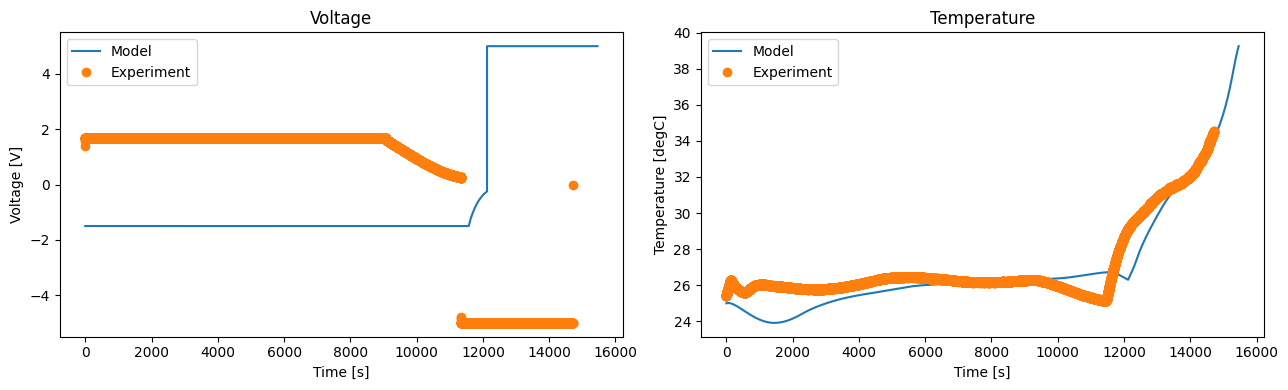

In [ ]:
# Compare model data to experiment

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(13, 4))

# plot the 1C results
t_sol = sol["Time [s]"].entries


ax1.plot(t_sol, sol["Current variable [A]"](t_sol))
ax1.plot(cycles_df.loc[1]["RelativeTime"],cycles_df.loc[1]["I"]/1000, "o")
ax1.set_xlabel("Time [s]")
ax1.set_ylabel("Voltage [V]")
ax1.set_title("Voltage")
ax1.legend(["Model", "Experiment"], loc="best")


ax2.plot(t_sol, sol["X-averaged cell temperature [C]"](t_sol))
ax2.plot(cycles_df.loc[1]["RelativeTime"],cycles_df.loc[1]["Temperature"], "o")
ax2.set_xlabel("Time [s]")
ax2.set_ylabel("Temperature [degC]")
ax2.set_title("Temperature")
ax2.legend(["Model", "Experiment"], loc="best")

plt.tight_layout()
plt.show()

下面是处理源数据的方法  


In [ ]:
import os
import pandas as pd
# 读取 CSV 文件
cwd = os.getcwd()
csv_file_path = cwd + '/exp_LG/allData_C7_removefront.csv'
Cell_7 = pd.read_csv(csv_file_path)

In [ ]:
# import os
# import pandas as pd
# # 读取 CSV 文件
# cwd = os.getcwd()
# csv_file_path = cwd + '/docs/source/examples/notebooks/models/exp_LG/allData_C7_removefront.csv'
# Cell_7 = pd.read_csv(csv_file_path)



In [ ]:
# Cell_7['RelativeTime'] = Cell_7['RelativeTime'] - Cell_7['RelativeTime'][0]

In [ ]:

# # 定义存储循环的列表
# cycles = []
# current_cycle = []
# charging = False

# # 遍历 DataFrame，识别循环
# for i, row in Cell_7.iterrows():
#     if row['Q_cha'] > 0 and not charging:
#         # 开始充电
#         charging = True
#         if current_cycle:
#             cycles.append(current_cycle)
#         current_cycle = [row]
#     elif row['Q_dis'] > 0 and charging:
#         # 结束充电，开始放电
#         charging = False
#         current_cycle.append(row)
#     else:
#         # 在当前循环中添加行
#         current_cycle.append(row)

# # 添加最后一个循环
# if current_cycle:
#     cycles.append(current_cycle)

# # 将循环数据转换为带有 MultiIndex 的 DataFrame
# cycle_data = []
# for cycle_num, cycle in enumerate(cycles):
#     for step_num, row in enumerate(cycle):
#         cycle_data.append((cycle_num + 1, step_num + 1, *row.values))

# # 定义多重索引
# multi_index = pd.MultiIndex.from_tuples(
#     [(cycle, step) for cycle, step, *rest in cycle_data],
#     names=['Cycle', 'Step']
# )

# # 定义 DataFrame 列名
# columns = ['Mode', 'RelativeTime', 'Voltage', 'I', 'Q_dis', 'Q_cha', 'Cap', 'R', 'Pressure', 'Temperature']

# # 创建最终的 DataFrame
# cycles_df = pd.DataFrame([rest for cycle, step, *rest in cycle_data], index=multi_index, columns=columns)

# # 打印前几行以验证
# print(cycles_df.head())

# # 示例：访问第一个循环的数据
# cycle_1_data = cycles_df.loc[1]
# print("\nCycle 1 Data:")
# print(cycle_1_data)

# # 示例：访问第一个循环的第一步数据
# cycle_1_step_1_data = cycles_df.loc[(1, 1)]
# print("\nCycle 1 Step 1 Data:")
# print(cycle_1_step_1_data)

In [ ]:
# 将 DataFrame 存储为 pickle 文件
# pickle_file_path = cwd + '/exp_LG/processed_data.pkl'
# cycles_df.to_pickle(pickle_file_path)
# print(f"DataFrame saved to {pickle_file_path}")

In [ ]:
# 将 DataFrame 存储为 pickle 文件
# pickle_file_path = cwd + '/docs/source/examples/notebooks/models/exp_LG/processed_data.pkl'
# cycles_df.to_pickle(pickle_file_path)
# print(f"DataFrame saved to {pickle_file_path}")